In [1]:
from torch.utils.data import DataLoader,ConcatDataset
from lib.datasets import EpochedDataset
from sklearn.model_selection import train_test_split
from lib.ekyn import *
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torch
from lib.ekyn import *
from torch import nn
from torch.nn.functional import relu
import torch
from lib.env import *
import math
import json


def gaussian_kernel(x, y, sigma=1.0):
    beta = 1. / (2. * sigma ** 2)
    dist = torch.cdist(x, y) ** 2
    s = torch.exp(-beta * dist)
    return s
def mmd_loss(outputs, labels):
    # Calculate the MMD loss between each class pair
    unique_labels = labels.unique()
    loss = 0.0
    count = 0
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            class_i_mask = (labels == unique_labels[i])
            class_j_mask = (labels == unique_labels[j])
            class_i_samples = outputs[class_i_mask]
            class_j_samples = outputs[class_j_mask]
            if len(class_i_samples) > 0 and len(class_j_samples) > 0:
                loss += gaussian_kernel(class_i_samples, class_i_samples).mean() + \
                        gaussian_kernel(class_j_samples, class_j_samples).mean() - \
                        2 * gaussian_kernel(class_i_samples, class_j_samples).mean()
                count += 1
    return loss / count if count > 0 else 0


train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
train_idx,test_idx = train_idx[:1],test_idx[:1]
print(train_idx,test_idx)
trainloader = DataLoader(ConcatDataset([EpochedDataset(id=id,condition=condition,downsampled=True) for id in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(id=id,condition=condition,downsampled=True) for id in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)

from lib.models import ResidualBlock

class Frodo(nn.Module):
    """
    the little wanderer
    """
    def __init__(self,n_features,device='cuda') -> None:
        super().__init__()
        self.n_features = n_features
        self.block1 = ResidualBlock(1,8,n_features)
        self.block2 = ResidualBlock(8,16,n_features)
        self.block3 = ResidualBlock(16,16,n_features)

        self.gap = nn.AvgPool1d(kernel_size=n_features)
        self.fc1 = nn.Linear(in_features=16,out_features=3)
    def forward(self,x):
        x = x.view(-1,1,self.n_features)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        embedding = self.gap(x)
        x = self.fc1(embedding.squeeze())
        return x,embedding

['F1-0'] ['A1-1']


In [2]:
model = Frodo(n_features=1000).cuda()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4,weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()
print(sum([p.flatten().size()[0] for p in list(model.parameters())]))

8187


In [3]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []

In [18]:
from tqdm import tqdm
from sklearn.metrics import f1_score

model.train()
for epoch in range(10):
    for (X_tr,y_tr) in tqdm(trainloader,leave=False):
        X_tr,y_tr = X_tr.to('cuda'),y_tr.to('cuda')
        logits,embedding = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
loss


tensor(0.2959, device='cuda:0', grad_fn=<DivBackward1>)

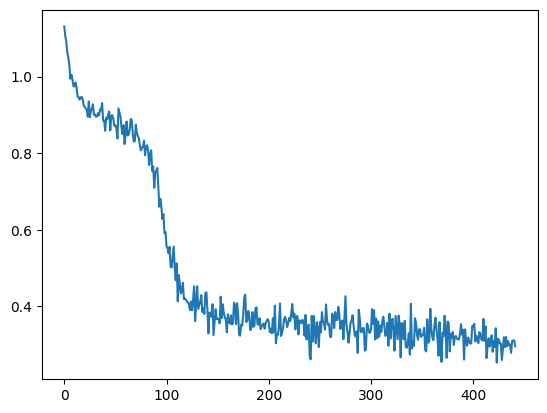

In [19]:
plt.plot(lossi)

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

/home/andrew/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/andrew/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 17280 samples in 0.005s...
[t-SNE] Computed neighbors for 17280 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17280
[t-SNE] Computed conditional probabilities for sample 2000 / 17280
[t-SNE] Computed conditional probabilities for sample 3000 / 17280
[t-SNE] Computed conditional probabilities for sample 4000 / 17280
[t-SNE] Computed conditional probabilities for sample 5000 / 17280
[t-SNE] Computed conditional probabilities for sample 6000 / 17280
[t-SNE] Computed conditional probabilities for sample 7000 / 17280
[t-SNE] Computed conditional probabilities for sample 8000 / 17280
[t-SNE] Computed conditional probabilities for sample 9000 / 17280
[t-SNE] Computed conditional probabilities for sample 10000 / 17280
[t-SNE] Computed conditional probabilities for sample 11000 / 17280
[t-SNE] Computed conditional probabilities for sample 12000 / 17280
[t-SNE] Computed conditional probabilities for sa

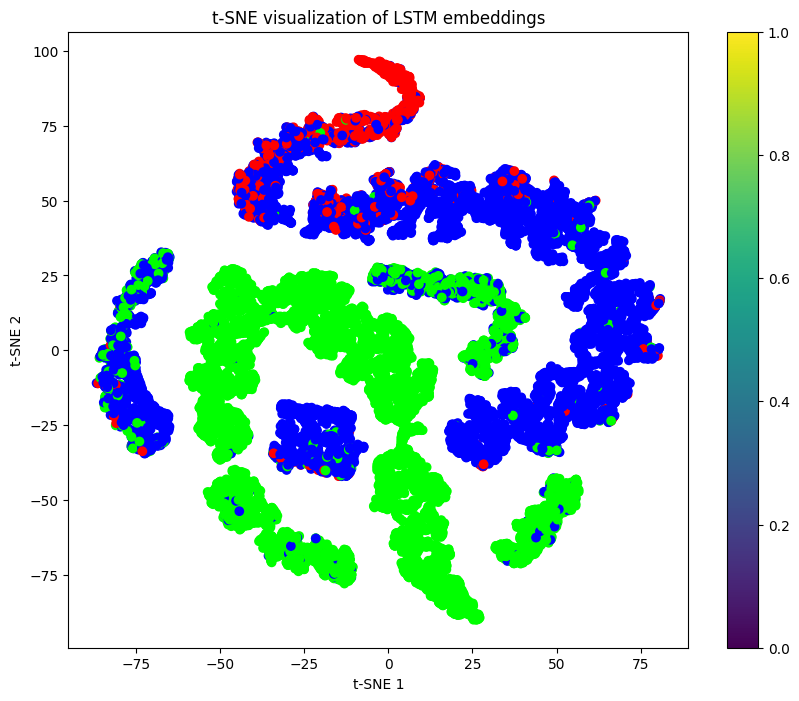

In [26]:
def evaluate_model(model, data_loader):
    model.eval()
    embeddings = []
    all_labels = []
    with torch.no_grad():
        for x, labels in data_loader:
            outputs,embedding = model(x.cuda())
            embeddings.append(outputs.squeeze())
            all_labels.append(labels)

    # Convert list of tensors to single tensor
    embeddings = torch.cat(embeddings).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    # Applying t-SNE to reduce dimensions to 2D
    tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000)
    tsne_results = tsne.fit_transform(embeddings)

    # Plotting the results of t-SNE
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, label=all_labels)
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of LSTM embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Call this function with the test loader or validation loader
evaluate_model(model, trainloader)

In [ ]:

y_true = []
y_pred = []
loss_tr_total = 0
    y_tr = y_tr.reshape(-1,3)
    y_true.append(y_tr.argmax(axis=1).cpu())

    loss_tr_total += loss.item()
    y_pred.append(torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu())
y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
trainlossi.append(loss_tr_total/len(trainloader))
trainf1.append(f1_score(y_true,y_pred,average='macro'))


In [ ]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
model.train()
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device='cuda')
    trainlossi.append(loss)
    trainf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=devloader,criterion=criterion,device='cuda')
    devlossi.append(loss)
    devf1.append(f1)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,4),dpi=200)
    ax[0].plot(trainlossi)
    ax[0].plot(devlossi)
    ax[0].set_title(label='loss',fontweight='bold')
    ax[0].set_xlabel('Epoch')
    ax[1].plot(trainf1)
    ax[1].plot(devf1)
    ax[1].set_title(label='f1',fontweight='bold')
    ax[1].set_xlabel('Epoch')

    plt.savefig('loss.jpg')
    plt.close()

In [ ]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)